In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cat_dog_builder = tfds.builder('cats_vs_dogs')
cat_dog_builder.download_and_prepare()
datasets = cat_dog_builder.as_dataset(shuffle_files = False)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZGNW8G/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
cad_orig = datasets['train']

In [0]:
def preprocess(example, size = (64,64)):
    image = example['image']
    label = example['label']
    image_grayscale = tf.image.rgb_to_grayscale(images = image, name = None)
    image_resized = tf.image.resize(image_grayscale, size = size)
    # image_resized = tf.image.resize(image, size = size)
    return tf.cast(image_resized/255.0, tf.float32), tf.cast(label, tf.int32)

In [0]:
cad_orig_resized = cad_orig.map(lambda x: preprocess(x, size = (128,128)))
# cad_orig = cad_orig.map(
    # lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                    # tf.cast(item['label'], tf.int32)))

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
NUM_EPOCHS = 15

In [0]:
tf.random.set_seed(1)

In [0]:
cad_train = cad_orig_resized.shuffle(buffer_size = BUFFER_SIZE,
                              reshuffle_each_iteration = False)
cad_valid = cad_train.take(np.ceil(23262*0.2)).batch(BATCH_SIZE)
cad_train = cad_train.skip(np.ceil(23262*0.2)).batch(BATCH_SIZE)

In [0]:


model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (5,5),
                                 input_shape=(128,128,1),
                                 padding = 'same',
                                 activation = 'relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)
                                ))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, (5,5), padding = 'same',
                                 activation = 'relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(64, (5,5), padding = 'same',
                                 activation = 'relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, (5,5), padding = 'same',
                                 activation = 'relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(rate = 0.5))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1024, activation = 'relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [0]:
# model.build(input_shape=(None, 128,128,1))

In [73]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
batch_normalization_34 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 64, 64)       

In [0]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy'])

In [75]:
history = model.fit(cad_train, epochs = NUM_EPOCHS,
                    validation_data = cad_valid,
                    shuffle = True) 

Epoch 1/15
582/582 [==============================] - 130s 223ms/step - loss: 1.9232 - accuracy: 0.6554 - val_loss: 48.4948 - val_accuracy: 0.4917
Epoch 2/15
582/582 [==============================] - 124s 214ms/step - loss: 1.3357 - accuracy: 0.7401 - val_loss: 1.2014 - val_accuracy: 0.7438
Epoch 3/15
582/582 [==============================] - 119s 204ms/step - loss: 1.1779 - accuracy: 0.7815 - val_loss: 1.2011 - val_accuracy: 0.7283
Epoch 4/15
582/582 [==============================] - 118s 203ms/step - loss: 1.1371 - accuracy: 0.8241 - val_loss: 1.3151 - val_accuracy: 0.7230
Epoch 5/15
582/582 [==============================] - 118s 203ms/step - loss: 1.1044 - accuracy: 0.8482 - val_loss: 1.1746 - val_accuracy: 0.7825
Epoch 6/15
582/582 [==============================] - 130s 223ms/step - loss: 1.0329 - accuracy: 0.8671 - val_loss: 1.1412 - val_accuracy: 0.8356
Epoch 7/15
582/582 [==============================] - 118s 203ms/step - loss: 1.0344 - accuracy: 0.8823 - val_loss: 1.3328 

In [0]:
model.save('cad_sgd.h5')


In [0]:
saved_model = tf.keras.models.load_model('cad_sgd.h5')

In [0]:
# import cv2

# img = cv2.imread(
#     '/content/drive/My Drive/data/cat-dog/cat6.jpeg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img,(128,128))
# img = np.reshape(img,[1,128,128,1])
# classes = saved_model.predict_classes(img)

# classes[0][0]

# class_label = {0: 'cat', 1: 'dog'}


# class_label[classes[0][0]]

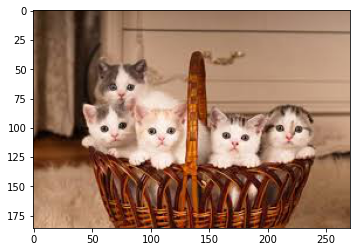

In [123]:
img = tf.keras.preprocessing.image.load_img(
    '/content/drive/My Drive/data/cat-dog/cat9.jpeg')
plt.imshow(img)

In [0]:
img = tf.io.read_file('/content/drive/My Drive/data/cat-dog/cat9.jpeg')
img = tf.image.decode_jpeg(img, channels = 3)
image_grayscale = tf.image.rgb_to_grayscale(images = img, name = None)
image_resized = tf.image.resize(image_grayscale, size = (128,128))
img = tf.cast(image_resized/255.0, tf.float32)

In [126]:
img = tf.reshape(img, [1,128,128,1])
img.shape

TensorShape([1, 128, 128, 1])

In [0]:
classes = saved_model.predict(img)

In [128]:
if classes[0][0] >0.5:
    print('Dog')
else: 
    print('Cat')

Cat
